### IMDB Dataset

* Internet Movie Database (IMDB)로부터 추출한 50,000개의 리뷰로 이루어진 데이터셋
* 25,000개의 훈련 데이터와 25,000개의 테스트 데이터
* 50% 긍정적 리뷰, 50% 부정적 리뷰

##### IMDB 데이터셋 로드하기

In [1]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = 10000)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/jhhur/anaconda3/envs/TIL2/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/jhhur/anaconda3/envs/TIL2/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or s

* `num_word = 10000` 파라미터는 훈련 데이터에 가장 잘 나타나는 단어 1만개만 사용하겠다는 뜻
* 드물게 나타나는 단어는 무시
* `train_labels`와 `test_labels`는
    * 0: 부정
    * 1: 긍정

가장 자주 등장하는 1만개의 단어를 사용했기에 단어 인덱스는 9999를 넘지 않는다.

In [2]:
max([max(sequence) for sequence in train_data])

9999

첫번째 리뷰 데이터를 원래 영어 단어로 바꿀려면:

In [3]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, "?") for i in train_data[0]])

decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

* `word_index()`는 단어와 정수 인덱스를 매핑한 dictionary
* 정수 인덱스와 단어를 매핑하도록 뒤집음
* 리뷰를 디코딩함. 0, 1, 2는 `패딩`, `문서 시작`, `사전에 없음`을 위한 인덱스 임으로 3을 뺌.

### 데이터 준비

신경망에 숫자 리스트를 주입할 수 없다. 리스트를 텐서로 바꾸어 주입하여야 한다.
1. 같은 길이가 되도록 리스트에 `Padding`을 추가하고 **(samples, sequence_length)** 크기의 정수 텐서로 변환한다.
2. 리스트를 `One-hot encoding`하여 0과 1의 벡터로 변환한다.
    * [3, 5] -> [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, .... , 0 ]

##### 정수 시퀀스를 이진 행렬로 인코딩하기

In [4]:
import numpy as np

def vectorize_sequences(sequences, dimension = 10000):
    results = np.zeros((len(sequences), dimension))
    
    for i, sequence in enumerate(sequences):
        results[i, sequence]  = 1.
    
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

```python
results = np.zeros((len(sequences), dimension))
```

* 크기가 (len(sequences), dimension))이고 모든 원소가 0인 행렬을 만든다


```python
results[i, sequence] = 1
```

* results[i]에서 특정 인덱스의 위치를 1로 만든다

샘플은 다음과 같이 나타난다.

```python
>>> x_train[0]
array([0., 1., 1., ..., 0., 0., 0.])
```

Label 역시 쉽게 벡터로 바꿀 수 있다.

In [5]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

### 신경망 모델 만들기

입력 데이터는 `벡터`이고 레이블은 `스칼라` (0 또는 1) 이다. 이런 문제에 잘 작동하는 네트워크 종류는 *relu* 활성화 함수를 사용한 완전한 연결 층을 쌓는 것이다.

`Dense(16, activation = 'relu')`

* Dense Layer에 전달된 parameter (16)은 Hidden Unit 의 개수이다.
* 하나의 은닉 유닛은 층이 나타내는 표현 공간에서 하나의 차원이 된다.
* 16개의 은닉 유닛이 있다는 것은 가중치 행렬 W의 크기가 (input_dimension, 16)이라는 뜻
    * `output = relu(dot(W, input) + b)
* 입력 데이터와 W를 점곱하면 입력 데이터가 16차원으로 표현된 공간으로 투영된다.
* 은닉 유닛을 늘리면 신경망이 더욱 복잡한 표현을 학습할 수 있지만 계산 비용이 커진다.

Dense 층을 쌓을때는 **두가지** 구조적 결정이 필요하다.
1. 얼마나 많은 층을 사용할 것인가?
2. 각 층에 얼마나 많은 은닉 유닛을 사용할 것인가?

이번 예제에서는 다음과 같은 구조를 사용한다.
1. 16개의 은닉 유닛을 가진 2개의 은닉 층
2. 현재 리뷰의 감정을 스칼라 값의 예측으로 출력하는 세번째 층

중간에 있는 은닉 층은 활성화 함수로 `relu`를 사용하고 마지막 층은 확률을 출력하기 위하여 `시그모이드` 활성화 함수를 사용한다.

`relu`는 음수를 0으로 만드는 함수이고, 시그모이드는 임의의 값을 [0, 1] 사이로 압축하므로 출력 값을 확률 처럼 해석할 수 있다.

![relu function](../images/3-4-relu.png)
![sigmoid function](../images/3-5-sigmoid.png)


##### 모델 정의하기

![network](../images/3-6-network.png)

In [6]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

마지막으로 손실 함수와 옵티마이저를 선택해야한다.
* 이진 분류 문제이고 신경망의 출력이 확률이기 때문에 `binary_crossentropy` 손실이 적합하다.
* 확률을 출력하는 모델을 사용할 때는 `crossentropy`가 최선의 선택이다.
    * **Crossentropy**는 확률 분포 간의 차이를 측정함.
    * 여기서는 원본 분포와 예측 분포 사이를 측정함.
* 다음은 `rmsprop` 옵티마이저와 `binary_crossentropy` 손실 함수로 모델을 설정하는 단계이다.

##### 모델 컴파일하기

In [7]:
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

Keras에 `rmsprop`, `binary_crossentropy`, `accuracy`가 포함되어있기 때문에 옵티마이저, 손실 함수, 측정 지표를 지정하는게 가능하다. 만약 옵티마이저의 파라미터를 바꾸거나, 자신만의 손실 함수, 측정 함수를 전달해야 한다면 파이썬 클래스를 사용해서 객체를 직접 만들어 파라미터에 전달하면 된다.

```python
from keras import optimizers
from keras import losses
from keras import metrics

model.compile(optimizer = optimizers.RMSprop(lr = 0.001),
              loss = losses.binary_crossentropy,
              metrics = [metrics.binary_accuracy])
```

### 훈련 검증

훈련하는 동안 처음 본 데이터에 대한 모델의 정확도를 측정하기 위해서 훈련 데이터에서 일부를 때어내어 **검증 세트 (Validation Set)**을 만들어야 한다.

##### 검증 세트 만들기

In [8]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

이제 모델을 *512개의 샘플씩 미니 배치를 만들어* 20번의 에포크 동안 훈련시킨다. 동시에 따로 떼어 놓은 1만개의 샘플에서 손실과 정확도를 측정할 것이다. 그러기 위해서는 **validation data**에 검증 데이터를 전달해야 한다.

##### 모델 훈련하기

In [9]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 21ms/step - loss: 0.5956 - accuracy: 0.6998 - val_loss: 0.3910 - val_accuracy: 0.8751
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3366 - accuracy: 0.8995 - val_loss: 0.3139 - val_accuracy: 0.8833
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2403 - accuracy: 0.9270 - val_loss: 0.2846 - val_accuracy: 0.8887
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1840 - accuracy: 0.9434 - val_loss: 0.2874 - val_accuracy: 0.8856
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1490 - accuracy: 0.9568 - val_loss: 0.2771 - val_accuracy: 0.8906
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1186 - accuracy: 0.9665 - val_loss: 0.2898 - val_accuracy: 0.8871
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0992 - accuracy: 0.9727 - val_loss: 0.3030 - val_accuracy: 0.8847
Epoch 8/20
30/30 [=

history 오브젝트에는 훈련하는 동안 발생한 모든 정보가 담겨있다. 이 딕셔너리는 훈련과 검증하는 동안 모니터링할 측정 지표당 하나씩 모두 4개의 항목을 담고 있다.

In [10]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

##### 훈련과 검증 손실 그리기

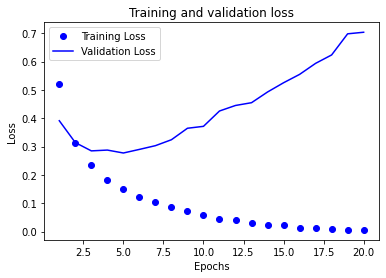

In [11]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label = "Training Loss")
plt.plot(epochs, val_loss, "b", label = "Validation Loss")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### 훈련과 검증  정확도 그리기

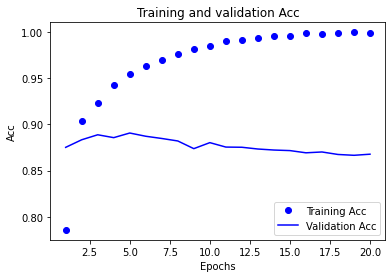

In [12]:
plt.clf() ## 그래프 초기화

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, "bo", label = "Training Acc")
plt.plot(epochs, val_acc, "b", label = "Validation Acc")
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

그래프에서 볼 수 있듯 *훈련 손실*은 에포크마다 감소하고 *훈련 정확도*는 증가한다. SGD를 사용했을때 반복마다 손실이 최소화되므로 기대했던 그래프이다. **검증** 손실과 정확도는 다르다. 네번째 에포크에서 그래프가 역전된다. 이는 훈련 세트에서 잘 작동하는 모델이 처음 보는 데이터에서는 잘 작동하지 않을 수 있다는 예시이다.

* 정확한 용어로는 **overfitting**되었다고 표현한다.

##### 처음부터 다시 훈련하기

In [13]:
model = models.Sequential()
model.add(layers.Dense(16, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs = 4, batch_size = 512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 1s 6ms/step - loss: 0.5553 - accuracy: 0.7625
Epoch 2/4
49/49 [==============================] - 0s 5ms/step - loss: 0.2839 - accuracy: 0.9082
Epoch 3/4
49/49 [==============================] - 0s 5ms/step - loss: 0.2097 - accuracy: 0.9272
Epoch 4/4
782/782 [==============================] - 1s 828us/step - loss: 0.3078 - accuracy: 0.8798


### 훈련된 모델로 새로운 데이터 예측하기

모델을 훈련시킨 후에 실전에서 사용하고 싶을 것이다. predict 메소드를 사용해서 예측할 수 있다.

In [14]:
model.predict(x_test)

array([[0.26225424],
       [0.9999516 ],
       [0.9573029 ],
       ...,
       [0.14002256],
       [0.11108565],
       [0.66763407]], dtype=float32)

In [15]:
y_test

array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)

### 정리

* 원본 데이터를 신경망에 턴서로 주입하기 위해서는 전처리가 필요하다.
* 출력 클래스가 2개인 이진 분류 문제에서는 네트워크는 `sigmoid` 활성화 함수를 가진 Dense 층으로 끝나야 한다.
    * 이 신경망의 출력은 확률을 나타내는 0과 1 사이의 스칼라 값이다
* 이진 분류 문제에서 Sigmoid 출력에 대해 사용할 손실 함수는 `binary_crossentropy`이다.
* `rmsprop` 옵티마이저는 문제에 상관없이 일반적으로 좋은 선택이다.